In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import time
import psutil
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Mount Google Drive
drive.mount('/content/drive')


# Define data paths
macro_folder = '/content/drive/MyDrive/processed_data'
financial_folder = '/content/drive/MyDrive/financial_info'

# Load data with proper handling
def load_country_data(country_name):
    # Define file paths based on country name (lowercase for consistency)
    country_lower = country_name.lower()
    stock_file = f'{financial_folder}/{country_lower}_stock.csv'
    macro_file = f'{macro_folder}/{country_lower}_macro.csv'

    # Load stock data - skip ticker symbol row (row 1)
    stock_df = pd.read_csv(stock_file, parse_dates=['Date'], skiprows=[1])

    # Load macro data
    macro_df = pd.read_csv(macro_file, parse_dates=['date'])

    print(f"Loaded {country_name} data: {stock_df.shape[0]} stock rows, {macro_df.shape[0]} macro rows")

    return stock_df, macro_df

# Process each country's data
countries = ['brazil', 'india', 'south_africa']
country_dfs = {}

for country in countries:
    stock_df, macro_df = load_country_data(country)
    country_dfs[country] = (stock_df, macro_df)


Mounted at /content/drive
Loaded brazil data: 148 stock rows, 52 macro rows
Loaded india data: 148 stock rows, 52 macro rows
Loaded south_africa data: 148 stock rows, 52 macro rows


In [ ]:
def preprocess_country_data(stock_df, macro_df, country_name):
    # Create copies to avoid modifying original data
    stock_df = stock_df.copy()
    macro_df = macro_df.copy()

    # Standardize all column names to lowercase
    stock_df.columns = [col.lower() for col in stock_df.columns]
    macro_df.columns = [col.lower() for col in macro_df.columns]

    # Ensure dates are properly formatted
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    macro_df['date'] = pd.to_datetime(macro_df['date'])

    # Convert stock close to numeric
    stock_df['close'] = pd.to_numeric(stock_df['close'], errors='coerce')

    # Calculate returns and volatility
    stock_df['return_1m'] = stock_df['close'].pct_change(1)
    stock_df['return_3m'] = stock_df['close'].pct_change(3)
    stock_df['volatility'] = stock_df['return_1m'].rolling(20).std()

    # Remove duplicated columns (keep only columns without suffix)
    macro_cols_to_keep = [col for col in macro_df.columns
                         if not col.endswith('_x') and not col.endswith('_y') and col != 'date']

    # Keep only unique columns
    macro_df = macro_df[['date'] + macro_cols_to_keep]

    # Convert all macro columns to numeric
    for col in macro_cols_to_keep:
        macro_df[col] = pd.to_numeric(macro_df[col], errors='coerce')

    # Forward fill missing values in macro data (critical for time series)
    macro_df = macro_df.sort_values('date').set_index('date')
    macro_df = macro_df.ffill()
    macro_df = macro_df.reset_index()

    # Merge stock and macro data
    df = pd.merge_asof(stock_df.sort_values('date'),
                      macro_df.sort_values('date'), on='date')

    # Calculate percentage changes for macro columns
    for col in macro_cols_to_keep:
        if col in df.columns:
            df[f'{col}_change'] = df[col].pct_change(1).fillna(0)

    df['country'] = country_name
    return df

# Process and combine data
processed_dfs = {}
for country in countries:
    stock_df, macro_df = country_dfs[country]
    processed_dfs[country] = preprocess_country_data(stock_df, macro_df, country)

combined_df = pd.concat(list(processed_dfs.values()))


In [ ]:
def define_market_regime(df):
    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Only calculate regimes based on rows with valid return and volatility
    mask = df_copy['return_1m'].notna() & df_copy['volatility'].notna()
    valid_data = df_copy[mask]

    # Calculate quantiles on valid data
    return_high = valid_data['return_1m'].quantile(0.7)
    return_low = valid_data['return_1m'].quantile(0.3)
    vol_high = valid_data['volatility'].quantile(0.7)

    # Define conditions for regime classification:
    # 0: Bear market (low returns, high volatility)
    # 1: Sideways market (moderate returns and volatility)
    # 2: Bull market (high returns)
    conditions = [
        (df_copy['return_1m'] < return_low) & (df_copy['volatility'] > vol_high),
        (df_copy['return_1m'] >= return_low) & (df_copy['return_1m'] <= return_high),
        (df_copy['return_1m'] > return_high)
    ]
    choices = [0, 1, 2]

    # Apply conditions to create regime column
    df_copy['regime'] = np.select(conditions, choices, default=1)

    return df_copy

# Define market regimes
combined_df = define_market_regime(combined_df)

# Display regime distribution
regime_counts = combined_df['regime'].value_counts()
print(f"Market Regime Distribution:\n{regime_counts}")


Market Regime Distribution:
regime
1    284
2    128
0     32
Name: count, dtype: int64


In [ ]:
# Select features for model training
features = ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi',
            'exchange_rate', 'imports', 'exports', 'gdp_change',
            'cpi_change', 'imports_change', 'exports_change']

# Keep only features that exist in the dataset
available_features = [f for f in features if f in combined_df.columns]
print(f"Available features: {available_features}")

# Handle missing values
for feature in available_features:
    if feature.endswith('_change'):
        combined_df[feature] = combined_df[feature].fillna(0)
    else:
        combined_df[feature] = combined_df[feature].fillna(combined_df[feature].median())

# Prepare data for RNN (create sequences)
def create_sequences(data, target, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Prepare input data (sorted by date for each country)
X_data = []
y_data = []

for country in countries:
    country_df = combined_df[combined_df['country'] == country].sort_values('date')
    X_country = country_df[available_features].values
    y_country = country_df['regime'].values

    # Create sequences for this country
    X_seq, y_seq = create_sequences(X_country, y_country, sequence_length=10)
    X_data.append(X_seq)
    y_data.append(y_seq)

# Combine country data
X = np.vstack(X_data)
y = np.concatenate(y_data)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target for training
y_onehot = tf.keras.utils.to_categorical(y_encoded)

# Split data with stratification by regime
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(n_samples, n_timesteps, n_features)

n_samples, n_timesteps, n_features = X_test.shape
X_test_reshaped = X_test.reshape(n_samples * n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(n_samples, n_timesteps, n_features)


Available features: ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi', 'exchange_rate', 'imports', 'exports', 'gdp_change', 'cpi_change', 'imports_change', 'exports_change']


In [ ]:
# Define RNN models
def create_simple_rnn(input_shape, output_shape):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape, return_sequences=True),
        SimpleRNN(32),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_lstm(input_shape, output_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_gru(input_shape, output_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        GRU(32),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_bidirectional_lstm(input_shape, output_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(32)),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_stacked_lstm(input_shape, output_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(48, return_sequences=True),
        LSTM(32),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define models for comparison
models = {
    'Simple RNN': create_simple_rnn,
    'LSTM': create_lstm,
    'GRU': create_gru,
    'Bidirectional LSTM': create_bidirectional_lstm,
    'Stacked LSTM': create_stacked_lstm
}

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Stratified k-fold cross-validation
k_values = [3, 5, 7]
cv_results = {}

input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

# Train models and collect metrics
train_results = {}
test_results = {}
training_times = {}
memory_usage = {}
feature_importances = {}

for name, model_fn in models.items():
    # Initialize results dictionaries
    train_results[name] = {}
    test_results[name] = {}

    print(f"\nTraining {name}...")

    # Measure training time and memory
    mem_before = psutil.virtual_memory().percent
    start_time = time.time()

    # Create and train model
    model = model_fn(input_shape, output_shape)
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Record training time and memory usage
    training_times[name] = time.time() - start_time
    mem_after = psutil.virtual_memory().percent
    memory_usage[name] = mem_after - mem_before

    # Predictions
    y_train_pred_prob = model.predict(X_train_scaled)
    y_test_pred_prob = model.predict(X_test_scaled)

    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    y_train_true = np.argmax(y_train, axis=1)
    y_test_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    train_results[name]['accuracy'] = accuracy_score(y_train_true, y_train_pred)
    train_results[name]['precision'] = precision_score(y_train_true, y_train_pred, average='weighted')
    train_results[name]['recall'] = recall_score(y_train_true, y_train_pred, average='weighted')
    train_results[name]['f1'] = f1_score(y_train_true, y_train_pred, average='weighted')

    test_results[name]['accuracy'] = accuracy_score(y_test_true, y_test_pred)
    test_results[name]['precision'] = precision_score(y_test_true, y_test_pred, average='weighted')
    test_results[name]['recall'] = recall_score(y_test_true, y_test_pred, average='weighted')
    test_results[name]['f1'] = f1_score(y_test_true, y_test_pred, average='weighted')

    # Cross-validation
    for k in k_values:
        if k not in cv_results:
            cv_results[k] = {}

        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        cv_scores = []

        for train_idx, val_idx in skf.split(X, y_encoded):
            # Create model
            cv_model = model_fn(input_shape, output_shape)

            # Train on fold
            X_fold_train, X_fold_val = X[train_idx], X[val_idx]
            y_fold_train = tf.keras.utils.to_categorical(y_encoded[train_idx])
            y_fold_val = tf.keras.utils.to_categorical(y_encoded[val_idx])

            # Scale
            n_samples, n_timesteps, n_features = X_fold_train.shape
            X_fold_train_reshaped = X_fold_train.reshape(n_samples * n_timesteps, n_features)
            X_fold_train_scaled = scaler.fit_transform(X_fold_train_reshaped).reshape(n_samples, n_timesteps, n_features)

            n_samples, n_timesteps, n_features = X_fold_val.shape
            X_fold_val_reshaped = X_fold_val.reshape(n_samples * n_timesteps, n_features)
            X_fold_val_scaled = scaler.transform(X_fold_val_reshaped).reshape(n_samples, n_timesteps, n_features)

            # Train
            cv_model.fit(X_fold_train_scaled, y_fold_train,
                        epochs=20, batch_size=32, verbose=0)

            # Evaluate
            _, accuracy = cv_model.evaluate(X_fold_val_scaled, y_fold_val, verbose=0)
            cv_scores.append(accuracy)

        cv_results[k][name] = {
            'mean': np.mean(cv_scores),
            'std': np.std(cv_scores)
        }

    # Calculate feature importance using permutation importance
    from sklearn.inspection import permutation_importance

    # Create a wrapper function to make the model compatible with sklearn
    def model_predict(X):
        X_reshaped = X.reshape(X.shape[0], X_train.shape[1], X_train.shape[2])
        return model.predict(X_reshaped)

    # Calculate permutation importance
    feature_importances[name] = {}
    for i, feature in enumerate(available_features):
        # Save original values
        original_values = X_test_scaled[:, :, i].copy()

        # Permute the feature
        permuted_X = X_test_scaled.copy()
        permuted_X[:, :, i] = np.random.permutation(permuted_X[:, :, i])

        # Calculate performance decrease
        original_accuracy = accuracy_score(y_test_true, np.argmax(model.predict(X_test_scaled), axis=1))
        permuted_accuracy = accuracy_score(y_test_true, np.argmax(model.predict(permuted_X), axis=1))
        importance = original_accuracy - permuted_accuracy

        # Store importance
        feature_importances[name][feature] = importance

        # Restore original values
        X_test_scaled[:, :, i] = original_values



Training Simple RNN...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━

Feature Importance for LSTM Model:
       Feature  Importance
     return_3m    0.024096
           cpi    0.012048
exports_change    0.012048
           gdp    0.000000
    cpi_change    0.000000
 exchange_rate    0.000000
       exports    0.000000
     return_1m   -0.012048
    volatility   -0.012048
       imports   -0.012048
    gdp_change   -0.012048
imports_change   -0.012048


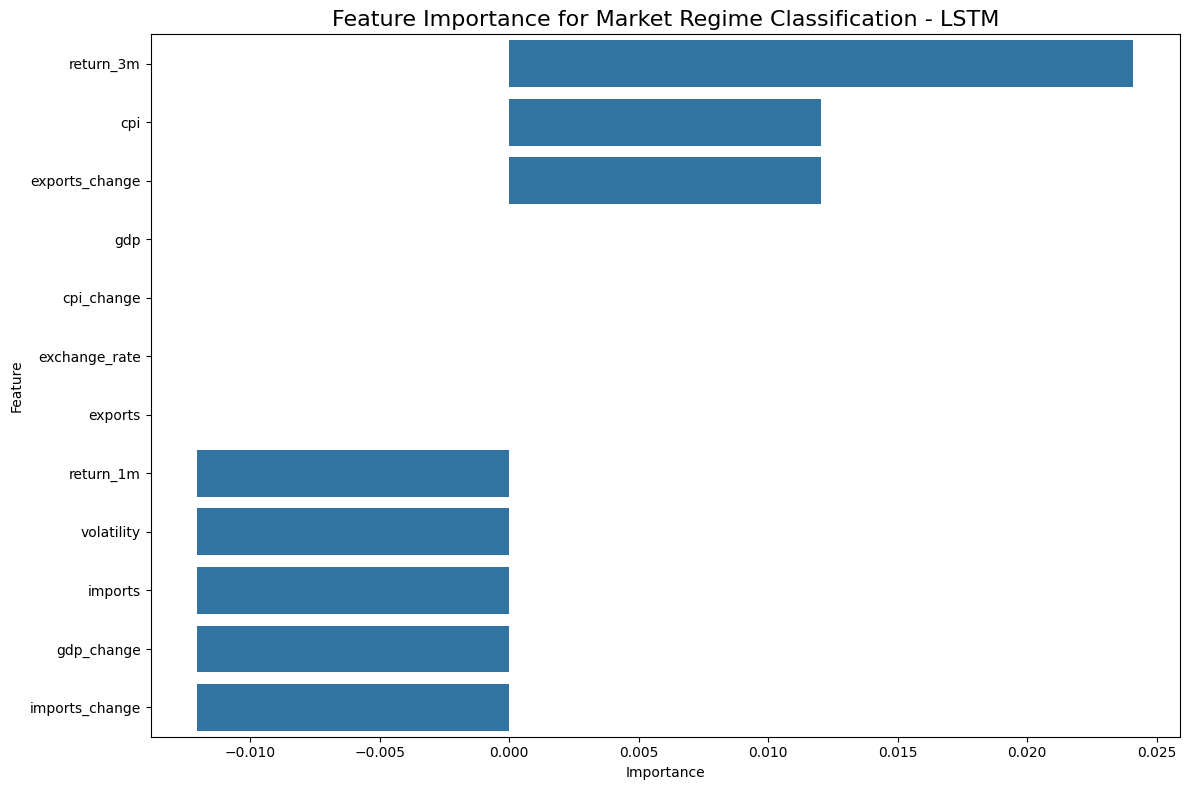

In [ ]:
# Display feature importance
def plot_feature_importance(feature_importances, model_name='LSTM'):
    importance_df = pd.DataFrame({
        'Feature': list(feature_importances[model_name].keys()),
        'Importance': list(feature_importances[model_name].values())
    }).sort_values('Importance', ascending=False)

    print(f"Feature Importance for {model_name} Model:")
    print(importance_df.to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance for Market Regime Classification - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

    return importance_df

# Display feature importance for best model (LSTM)
importance_table = plot_feature_importance(feature_importances, 'LSTM')


In [ ]:
# Display training results
train_df = pd.DataFrame({
    model: {metric: value for metric, value in results.items()}
    for model, results in train_results.items()
}).T
print("Training Set Performance Metrics:")
print(train_df.round(4))


Training Set Performance Metrics:
                    accuracy  precision  recall      f1
Simple RNN            0.7523     0.7490  0.7523  0.7367
LSTM                  0.6828     0.6494  0.6828  0.6287
GRU                   0.6405     0.6031  0.6405  0.5591
Bidirectional LSTM    0.6647     0.6197  0.6647  0.5948
Stacked LSTM          0.6647     0.6201  0.6647  0.5979


In [ ]:
# Display test results
test_df = pd.DataFrame({
    model: {metric: value for metric, value in results.items()}
    for model, results in test_results.items()
}).T
print("Test Set Performance Metrics:")
print(test_df.round(4))


Test Set Performance Metrics:
                    accuracy  precision  recall      f1
Simple RNN            0.5542     0.5308  0.5542  0.5374
LSTM                  0.6024     0.4983  0.6024  0.5205
GRU                   0.6386     0.6275  0.6386  0.5442
Bidirectional LSTM    0.6506     0.5904  0.6506  0.5518
Stacked LSTM          0.6145     0.5141  0.6145  0.5124


In [ ]:
# Calculate overfitting metrics
overfitting_df = pd.DataFrame(index=train_df.index, columns=train_df.columns)
for model in train_df.index:
    for metric in train_df.columns:
        overfitting_df.loc[model, metric] = abs(train_df.loc[model, metric] - test_df.loc[model, metric])
print("Overfitting Analysis (|Train - Test|):")
print(overfitting_df.round(4))


Overfitting Analysis (|Train - Test|):
                    accuracy precision    recall        f1
Simple RNN          0.198049    0.2182  0.198049  0.199256
LSTM                 0.08037  0.151055   0.08037  0.108176
GRU                 0.001929  0.024438  0.001929  0.014874
Bidirectional LSTM   0.01405  0.029378   0.01405   0.04301
Stacked LSTM        0.050195   0.10603  0.050195  0.085409


In [ ]:
# Display training times
time_df = pd.DataFrame.from_dict(training_times, orient='index', columns=['Training Time (seconds)'])
print("Training Time (seconds):")
print(time_df.round(2))


Training Time (seconds):
                    Training Time (seconds)
Simple RNN                             5.48
LSTM                                   5.49
GRU                                    8.69
Bidirectional LSTM                     9.11
Stacked LSTM                           8.55


In [ ]:
# Display RAM usage
ram_df = pd.DataFrame.from_dict(memory_usage, orient='index', columns=['RAM Usage (% increase)'])
print("RAM Usage (% increase):")
print(ram_df.round(2))


RAM Usage (% increase):
                    RAM Usage (% increase)
Simple RNN                             0.3
LSTM                                   0.4
GRU                                   -0.5
Bidirectional LSTM                     0.7
Stacked LSTM                           0.6


In [ ]:
# Display cross-validation results
for k in k_values:
    cv_df = pd.DataFrame({
        model: {
            'Mean Accuracy': results['mean'],
            'Std Deviation': results['std']
        } for model, results in cv_results[k].items()
    }).T
    print(f"\nCross-Validation Results (k={k}):")
    print(cv_df.round(4))



Cross-Validation Results (k=3):
                    Mean Accuracy  Std Deviation
Simple RNN                 0.5845         0.0403
LSTM                       0.6256         0.0123
GRU                        0.6329         0.0149
Bidirectional LSTM         0.6087         0.0000
Stacked LSTM               0.6063         0.0137

Cross-Validation Results (k=5):
                    Mean Accuracy  Std Deviation
Simple RNN                 0.5964         0.0505
LSTM                       0.6206         0.0412
GRU                        0.6110         0.0432
Bidirectional LSTM         0.6134         0.0289
Stacked LSTM               0.6061         0.0311

Cross-Validation Results (k=7):
                    Mean Accuracy  Std Deviation
Simple RNN                 0.5603         0.0345
LSTM                       0.6183         0.0242
GRU                        0.6400         0.0386
Bidirectional LSTM         0.6303         0.0288
Stacked LSTM               0.5966         0.0142


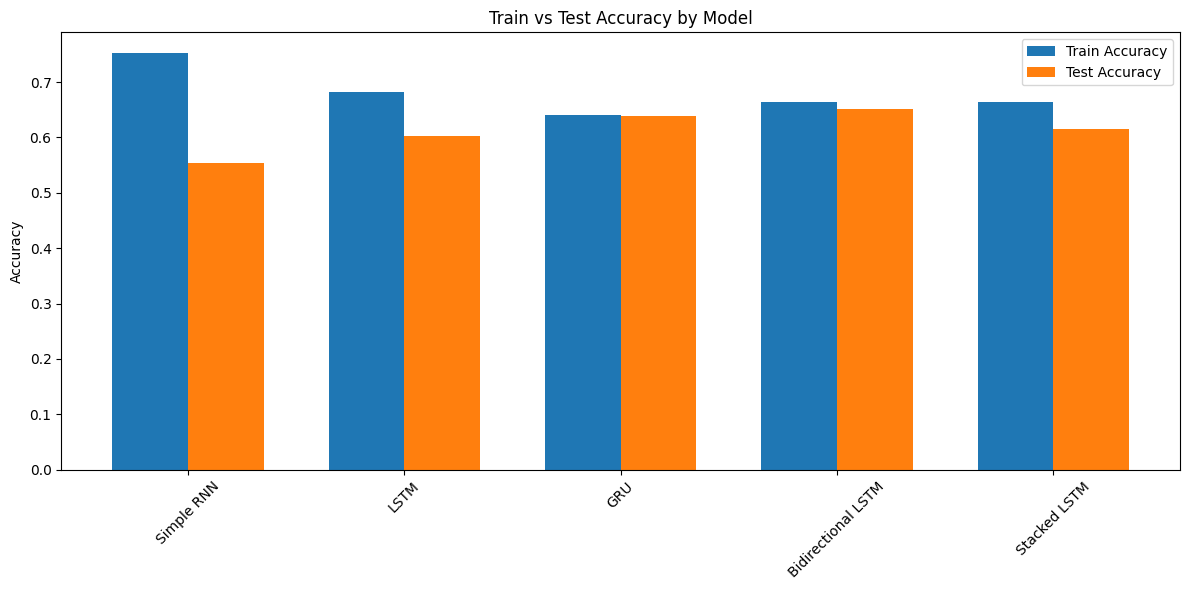

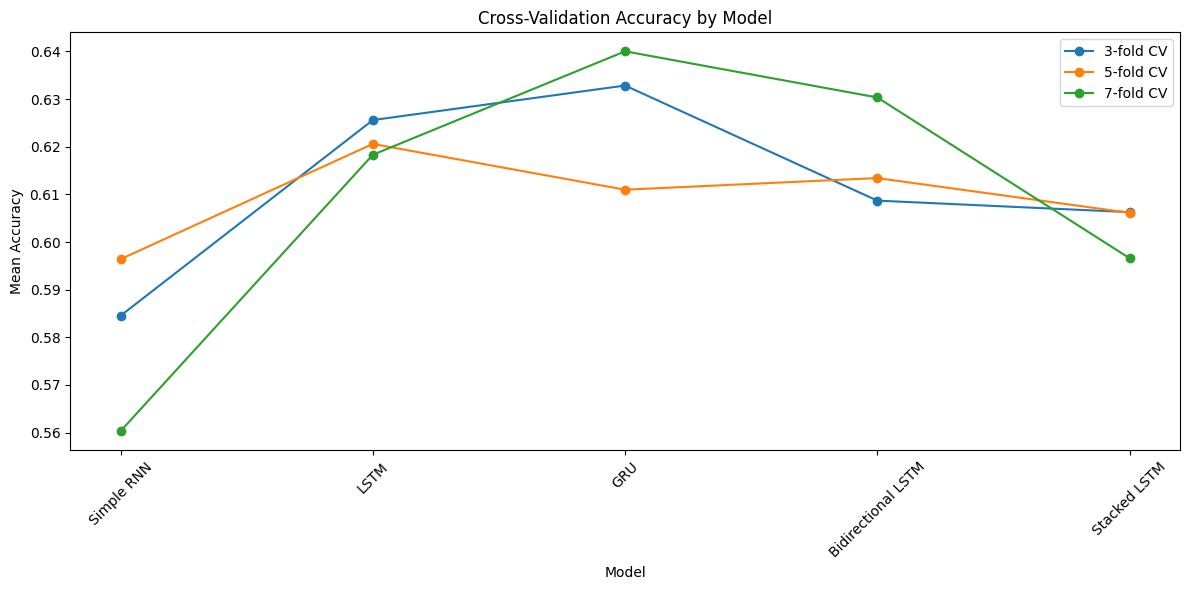

In [ ]:
# Plot model performance comparison
plt.figure(figsize=(12, 6))
model_names = list(models.keys())
train_acc = [train_results[m]['accuracy'] for m in model_names]
test_acc = [test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, train_acc, width, label='Train Accuracy')
plt.bar(x + width/2, test_acc, width, label='Test Accuracy')
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_table)
plt.title('Top Features for Market Regime Classification', fontsize=16)
plt.tight_layout()
plt.show()

# Plot cross-validation results
plt.figure(figsize=(12, 6))
for k in k_values:
    mean_accuracies = [cv_results[k][model]['mean'] for model in model_names]
    plt.plot(model_names, mean_accuracies, marker='o', label=f'{k}-fold CV')
plt.title('Cross-Validation Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



Processing BRAZIL
Loaded brazil data: 148 stock rows, 52 macro rows
Loaded data. Shape: (148, 22)
Regime distribution:
regime
1    91
2    44
0    13
Name: count, dtype: int64
Using features: ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi', 'exchange_rate', 'imports', 'exports', 'gdp_change', 'cpi_change', 'imports_change', 'exports_change']
Created sequences. X shape: (138, 10, 12), y shape: (138,)
Training RNN model for brazil...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.4020 - loss: 1.0815 - val_accuracy: 0.5909 - val_loss: 1.0175
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5327 - loss: 1.0179 - val_accuracy: 0.5909 - val_loss: 0.9648
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5827 - loss: 0.9601 - val_accuracy: 0.5909 - val_loss: 0.9224
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6193 - loss: 0.9140 - val_accuracy: 0.5909 - val_loss: 0.8856
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accur

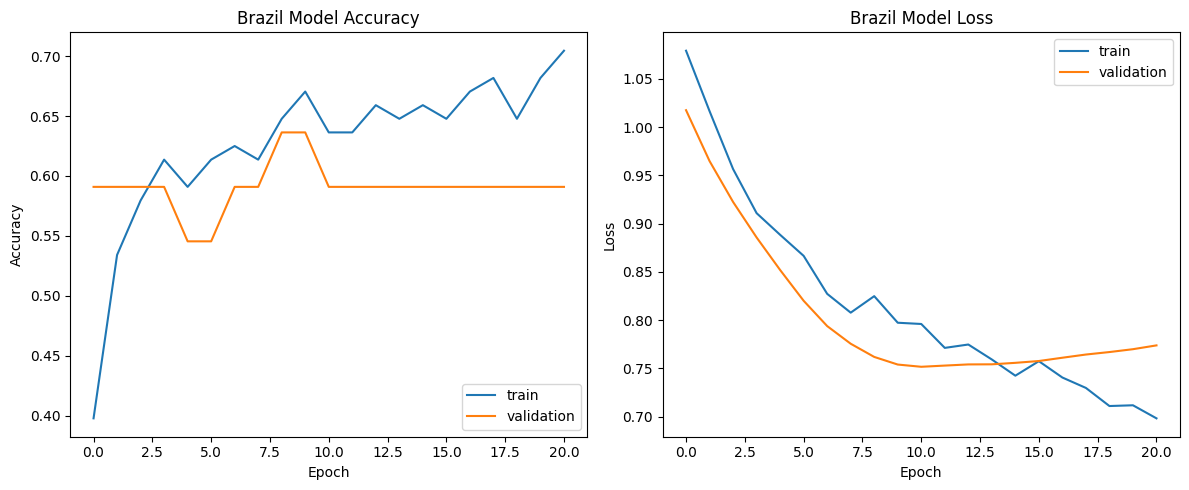

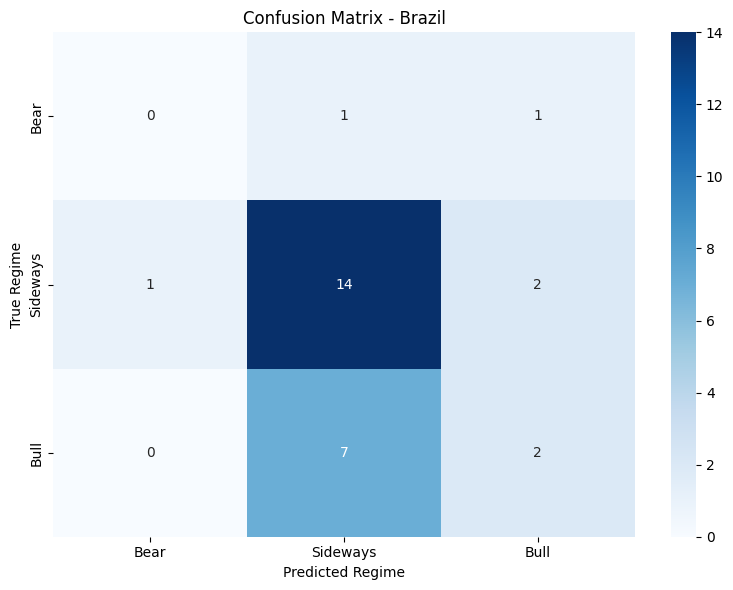


Processing INDIA
Loaded india data: 148 stock rows, 52 macro rows
Loaded data. Shape: (148, 22)
Regime distribution:
regime
1    92
2    45
0    11
Name: count, dtype: int64
Using features: ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi', 'exchange_rate', 'imports', 'exports', 'gdp_change', 'cpi_change', 'imports_change', 'exports_change']
Created sequences. X shape: (138, 10, 12), y shape: (138,)
Training RNN model for india...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.2788 - loss: 1.1377 - val_accuracy: 0.3636 - val_loss: 1.1250
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3714 - loss: 1.0748 - val_accuracy: 0.5909 - val_loss: 1.0513
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4947 - loss: 1.0191 - val_accuracy: 0.6818 - val_loss: 0.9847
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5401 - loss: 1.0084 - val_accuracy: 0.6364 - val_loss: 0.9241
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy


Processing SOUTH_AFRICA
Loaded south_africa data: 148 stock rows, 52 macro rows
Loaded data. Shape: (148, 26)
Regime distribution:
regime
1    98
2    42
0     8
Name: count, dtype: int64
Using features: ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi', 'exchange_rate', 'imports', 'exports', 'gdp_change', 'cpi_change', 'imports_change', 'exports_change']
Created sequences. X shape: (138, 10, 12), y shape: (138,)
Training RNN model for south_africa...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.4496 - loss: 1.0873 - val_accuracy: 0.4545 - val_loss: 1.0838
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4844 - loss: 1.0211 - val_accuracy: 0.5000 - val_loss: 1.0556
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5788 - loss: 0.9950 - val_accuracy: 0.5455 - val_loss: 1.0279
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6229 - loss: 0.9598 - val_accuracy: 0.5455 - val_loss: 0.9977
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

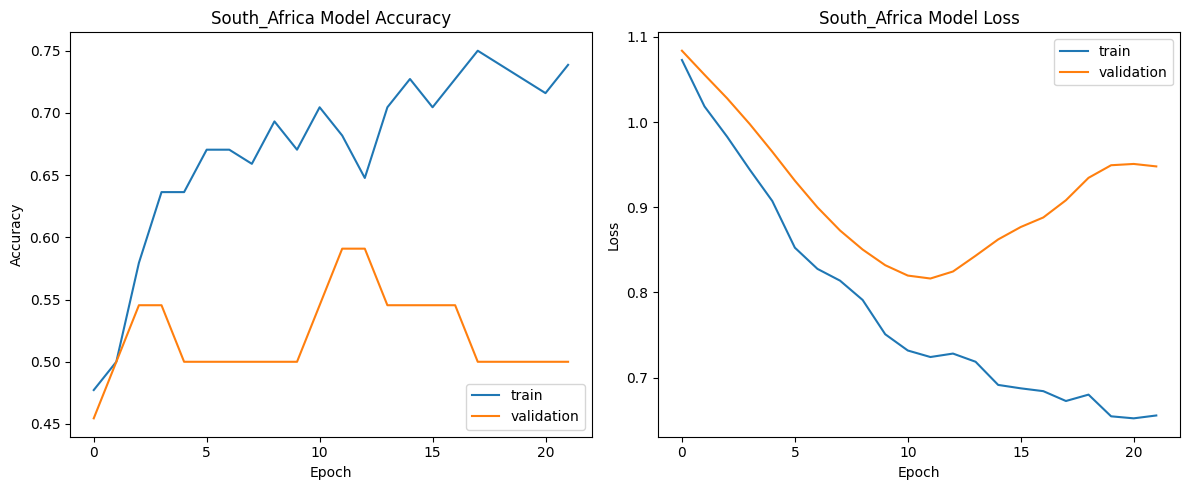


Summary of Results:
Brazil: Accuracy = 0.5714, Training Time = 6.92s
India: Accuracy = 0.6786, Training Time = 8.30s
South_Africa: Accuracy = 0.5714, Training Time = 6.82s


In [ ]:
def run_market_regime_analysis():
    """Main function to run the entire market regime classification pipeline with debugging and country-wise predictions"""
    import numpy as np
    import tensorflow as tf
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report
    import time
    import psutil
    import matplotlib.pyplot as plt

    # Define countries to analyze
    countries = ['brazil', 'india', 'south_africa']

    # Store results
    results = {}

    # Define sequence parameters and features
    sequence_length = 10
    features = ['return_1m', 'return_3m', 'volatility', 'gdp', 'cpi',
                'exchange_rate', 'imports', 'exports', 'gdp_change',
                'cpi_change', 'imports_change', 'exports_change']

    # Label encoder for regimes
    label_encoder = LabelEncoder()

    for country in countries:
        print(f"\n{'='*50}")
        print(f"Processing {country.upper()}")
        print(f"{'='*50}")

        try:
            # Load and preprocess data (replaces load_and_process_data)
            stock_df, macro_df = load_country_data(country)
            combined_df = preprocess_country_data(stock_df, macro_df, country)

            if combined_df is None or combined_df.empty:
                print(f"No valid data for {country}")
                continue

            print(f"Loaded data. Shape: {combined_df.shape}")

            # Define market regimes (replaces label_market_regimes)
            labeled_data = define_market_regime(combined_df)

            if labeled_data is not None:
                print("Regime distribution:")
                print(labeled_data['regime'].value_counts())

            # Filter available features (part of feature engineering)
            available_features = [f for f in features if f in labeled_data.columns]
            print(f"Using features: {available_features}")

            # Handle missing values
            for feature in available_features:
                if feature.endswith('_change'):
                    labeled_data[feature] = labeled_data[feature].fillna(0)
                else:
                    labeled_data[feature] = labeled_data[feature].fillna(labeled_data[feature].median())

            # Create sequences for RNN (replaces engineer_features)
            country_df = labeled_data.sort_values('date')
            X_country = country_df[available_features].values
            y_country = country_df['regime'].values

            # Create sequences
            def create_sequences(data, target, seq_len):
                X, y = [], []
                for i in range(len(data) - seq_len):
                    X.append(data[i:i+seq_len])
                    y.append(target[i+seq_len])
                return np.array(X), np.array(y)

            X_seq, y_seq = create_sequences(X_country, y_country, sequence_length)
            print(f"Created sequences. X shape: {X_seq.shape}, y shape: {y_seq.shape}")

            # Encode target
            y_encoded = label_encoder.fit_transform(y_seq)
            y_onehot = tf.keras.utils.to_categorical(y_encoded)

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_seq, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

            # Scale features
            scaler = StandardScaler()
            n_samples, n_timesteps, n_features = X_train.shape
            X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
            X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(n_samples, n_timesteps, n_features)

            n_samples, n_timesteps, n_features = X_test.shape
            X_test_reshaped = X_test.reshape(n_samples * n_timesteps, n_features)
            X_test_scaled = scaler.transform(X_test_reshaped).reshape(n_samples, n_timesteps, n_features)

            # Debug model training and evaluation (replace debug_model_training)
            print(f"Training RNN model for {country}...")

            # Define the RNN model
            from tensorflow.keras.models import Sequential
            from tensorflow.keras.layers import LSTM, Dense, Dropout
            from tensorflow.keras.optimizers import Adam
            from tensorflow.keras.callbacks import EarlyStopping

            # Create model with early stopping to prevent overfitting
            model = Sequential([
                LSTM(64, input_shape=(sequence_length, len(available_features)), return_sequences=True),
                Dropout(0.2),
                LSTM(32),
                Dropout(0.2),
                Dense(y_onehot.shape[1], activation='softmax')
            ])

            model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            # Track training time and memory usage
            mem_before = psutil.virtual_memory().percent
            start_time = time.time()

            # Train model with validation split
            history = model.fit(
                X_train_scaled, y_train,
                epochs=50,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )

            training_time = time.time() - start_time
            mem_after = psutil.virtual_memory().percent
            ram_usage = mem_after - mem_before

            # Predictions
            y_pred_prob = model.predict(X_test_scaled)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_true = np.argmax(y_test, axis=1)

            # Performance metrics
            accuracy = accuracy_score(y_true, y_pred)
            class_report = classification_report(y_true, y_pred)

            print(f"{country.title()} - Test Accuracy: {accuracy:.4f}")
            print("Classification Report:")
            print(class_report)

            # Plot training history
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title(f'{country.title()} Model Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['train', 'test'], loc='lower right')

            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title(f'{country.title()} Model Loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['train', 'test'], loc='upper right')
            plt.tight_layout()
            plt.show()

            # Plot confusion matrix
            from sklearn.metrics import confusion_matrix
            import seaborn as sns

            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Bear', 'Sideways', 'Bull'],
                        yticklabels=['Bear', 'Sideways', 'Bull'])
            plt.title(f'Confusion Matrix - {country.title()}')
            plt.ylabel('True Regime')
            plt.xlabel('Predicted Regime')
            plt.tight_layout()
            plt.show()

            # Store results
            results[country] = {
                'model': model,
                'accuracy': accuracy,
                'training_time': training_time,
                'ram_usage': ram_usage,
                'confusion_matrix': cm,
                'y_pred': y_pred,
                'y_true': y_true
            }

        except Exception as e:
            print(f"Error analyzing {country}: {str(e)}")
            import traceback
            traceback.print_exc()

    # Print summary
    print("\nSummary of Results:")
    for country, result in results.items():
        accuracy = result.get('accuracy')
        if accuracy is not None:
            print(f"{country.title()}: Accuracy = {accuracy:.4f}, Training Time = {result['training_time']:.2f}s")
        else:
            print(f"{country.title()}: Analysis failed")

    return results

# Run the adapted analysis
if __name__ == "__main__":
    results = run_market_regime_analysis()
